**Goal of the project**

The goal of this project is to create a fare prediction model for ride hailing companies Uber and Lyft in the Greater Boston area. The dataset can be [downloaded from Kaggle here](https://www.kaggle.com/datasets/brllrb/uber-and-lyft-dataset-boston-ma).

**Load the packages**

In [32]:
import pandas as pd
import numpy as np

**Load and preprocess data**

In [34]:
# Load dataset
df = pd.read_csv('../input/uber-and-lyft-dataset-boston-ma/rideshare_kaggle.csv')

In [35]:
# Rename Pandas columns to lower case
df.columns = df.columns.str.lower()

In [36]:
df = df.applymap(lambda s: s.lower() if type(s) == str else s)

In [37]:
# Examine the data
df.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,precipintensitymax,uvindextime,temperaturemin,temperaturemintime,temperaturemax,temperaturemaxtime,apparenttemperaturemin,apparenttemperaturemintime,apparenttemperaturemax,apparenttemperaturemaxtime
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,16,12,2018-12-16 09:30:07,america/new_york,haymarket square,north station,lyft,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,27,11,2018-11-27 02:00:23,america/new_york,haymarket square,north station,lyft,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,1,28,11,2018-11-28 01:00:22,america/new_york,haymarket square,north station,lyft,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,4,30,11,2018-11-30 04:53:02,america/new_york,haymarket square,north station,lyft,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,3,29,11,2018-11-29 03:49:20,america/new_york,haymarket square,north station,lyft,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800


In [38]:
# Overview of all variables, their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           693071 non-null  object 
 1   timestamp                    693071 non-null  float64
 2   hour                         693071 non-null  int64  
 3   day                          693071 non-null  int64  
 4   month                        693071 non-null  int64  
 5   datetime                     693071 non-null  object 
 6   timezone                     693071 non-null  object 
 7   source                       693071 non-null  object 
 8   destination                  693071 non-null  object 
 9   cab_type                     693071 non-null  object 
 10  product_id                   693071 non-null  object 
 11  name                         693071 non-null  object 
 12  price                        637976 non-null  float64
 13 

**Check for missing values**

In [39]:
df.isnull().sum()

id                                 0
timestamp                          0
hour                               0
day                                0
month                              0
datetime                           0
timezone                           0
source                             0
destination                        0
cab_type                           0
product_id                         0
name                               0
price                          55095
distance                           0
surge_multiplier                   0
latitude                           0
longitude                          0
temperature                        0
apparenttemperature                0
short_summary                      0
long_summary                       0
precipintensity                    0
precipprobability                  0
humidity                           0
windspeed                          0
windgust                           0
windgusttime                       0
v

In [40]:
# Drop all rows that have any NaN values
df = df.dropna()

In [41]:
# Drop unnecessary columns
df = df.drop(['id', 'timestamp', 'datetime', 'timezone', 'product_id'], axis = 1)

In [42]:
import ktrain
from ktrain import tabular

In [43]:
trn, val, preproc = tabular.tabular_from_df(df, is_regression = True, label_columns = 'price', random_state = 42)

processing train: 574312 rows x 52 columns
['price']


/opt/conda/lib/python3.7/site-packages/ktrain/utils.py:723: UserWarning: Task is being treated as REGRESSION because either class_names argument was not supplied or is_regression=True. If this is incorrect, change accordingly.
  + "If this is incorrect, change accordingly."


   price
0    5.0
2    7.0
3   26.0
4    9.0
5   16.5

The following integer column(s) are being treated as categorical variables:
['day', 'month', 'uvindex', 'uvindextime']
To treat any of these column(s) as numerical, cast the column to float in DataFrame or CSV
 and re-run tabular_from* function.

processing test: 63664 rows x 52 columns
['price']
    price
1    11.0
11    7.0
35   26.0
36   16.5
46   16.5


**Create model and wrap in learner**

We'll use tabular_regression_model to create a regression model.

In [44]:
model = tabular.tabular_regression_model('mlp', trn)
learner = ktrain.get_learner(model, train_data = trn, val_data = val, batch_size = 1024)

done.


**Estimate a good learning rate**

To train the model, we will first find the optimal learning rate that suits well to our problem. ktrain provides a very good method named lr_find which trains the model at different learning rates and plots loss of the model as the learning rate is increased.

In [45]:
learner.lr_find(max_epochs = 3)

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
560/560 [==============================] - 64s 110ms/step - loss: 329.2708 - mae: 15.4468
Epoch 2/3
560/560 [==============================] - 62s 110ms/step - loss: 27.3732 - mae: 3.3027
Epoch 3/3
560/560 [==============================] - 24s 42ms/step - loss: 162.6965 - mae: 5.3248


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


The learning rate plot can be observed by calling the following method:

Three possible suggestions for LR from plot:
	Longest valley (red): 5.12E-04
	Min numerical gradient (purple): 3.27E-05
	Min loss divided by 10 (omitted from plot): 3.03E-03


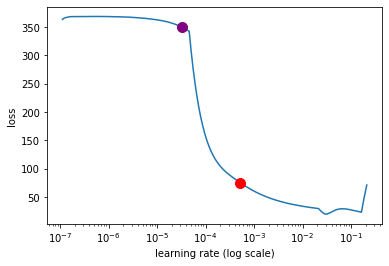

In [46]:
learner.lr_plot(suggest = True)

**Train**

According to our final validation MAE (see below), our fare predictions are only off about ~$1.13.

In [47]:
learner.autofit(5.12E-04, early_stopping = 2)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.000512...
Epoch 1/1024
561/561 [==============================] - 131s 230ms/step - loss: 49.2965 - mae: 4.2311 - val_loss: 4.4898 - val_mae: 1.4358
Epoch 2/1024
561/561 [==============================] - 128s 229ms/step - loss: 4.1652 - mae: 1.3875 - val_loss: 3.7574 - val_mae: 1.3280
Epoch 3/1024
561/561 [==============================] - 129s 229ms/step - loss: 3.6561 - mae: 1.3106 - val_loss: 3.4698 - val_mae: 1.2746
Epoch 4/1024
561/561 [==============================] - 129s 229ms/step - loss: 3.4567 - mae: 1.2732 - val_loss: 3.3438 - val_mae: 1.2452
Epoch 5/1024
561/561 [==============================] - 129s 229ms/step - loss: 3.3456 - mae: 1.2465 - val_loss: 3.2549 - val_mae: 1.2230
Epoch 6/1024
561/561 [==============================] - 131s 234ms/step - loss: 3.2710 - mae: 1.2260 - val_loss: 3.1995 - val_mae: 1.2039
Epoch 7/1024
561/561 [=============

In [48]:
learner.evaluate(test_data = val)

[('mae', 1.1272479)]